# Transfer Learning

## VGG16とInceptionV3で転移学習

Dataset
>https://www.kaggle.com/moltean/fruits

Dataset properties
Total number of images: 49606.

Training set size: 37101 images (one fruit per image).

Test set size: 12460 images (one fruit per image).

Multi-fruits set size: 45 images (more than one fruit (or fruit class) per image)

Number of classes: 74 (fruits).

## ライブラリのインポート

In [2]:
import tensorflow as tf            
import pandas as pd                 
import numpy as np                                       
import sklearn.model_selection     # For using KFold
import keras.preprocessing.image   # For using image generation
import datetime                    # To measure running time 
import skimage.transform           # For resizing images
import skimage.morphology          # For using image labeling
import cv2                         # To read and manipulate images
import os                          # For filepath, directory handling
import sys                         # System-specific parameters and functions
import tqdm                        # Use smart progress meter
import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm    

In [3]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
training_paths = pathlib.Path('./fruits-360/Training').glob('*/*.jpg')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[30000]
im = imageio.imread(str(im_path))
# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

Original image shape: (100, 100, 3)


 ## サンプル画像を参照

Text(0.5,1,'Original Image')

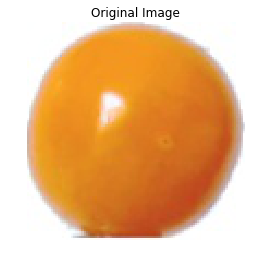

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Now, let's plot the data

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

## CNN(by keras)で学習

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
#GPUのメモリ確保

import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config)
K.set_session(sess)

In [6]:
import cv2
import os
from keras.utils import np_utils

def load_images(path):
    img_data=[]
    labels=[]
    idx_to_label = []
    i = -1
    for fruit in next(os.walk(path))[1]:   #  os.listdir(path):
        fruit_path = os.path.join(path,fruit)
        labels.append(fruit)
        i = i+1
        for img in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path,img)
            idx_to_label.append(i)
            image = cv2.imread(img_path)
           # image = cv2.resize(image, (64, 64))
            
          #  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            img_data.append(image)
    return np.array(img_data),np.array(idx_to_label),labels  
        

In [7]:
train_data_path = './fruits-360/Training'
test_data_path = './fruits-360/Test'
x,y,labels_data = load_images(train_data_path)

#X_train,y_train,label_data = load_images(trn_data_path)
print(x.shape)
print(y.shape)
print(labels_data)
X_test,y_test,label_data_garbage = load_images(test_data_path)

(37101, 100, 100, 3)
(37101,)
['Apple Red Delicious', 'Huckleberry', 'Melon Piel de Sapo', 'Pear', 'Cherry 1', 'Strawberry', 'Avocado', 'Pomegranate', 'Dates', 'Carambula', 'Granadilla', 'Tamarillo', 'Kiwi', 'Cherry Wax Yellow', 'Lemon', 'Guava', 'Apple Golden 2', 'Apple Red 1', 'Mandarine', 'Quince', 'Strawberry Wedge', 'Pear Monster', 'Raspberry', 'Pitahaya Red', 'Apple Golden 3', 'Grape Pink', 'Banana Red', 'Physalis', 'Cherry Rainier', 'Maracuja', 'Plum', 'Nectarine', 'Cherry Wax Black', 'Cantaloupe 2', 'Lychee', 'Clementine', 'Cherry 2', 'Pineapple Mini', 'Rambutan', 'Grape White', 'Apple Braeburn', 'Mango', 'Cocos', 'Mulberry', 'Avocado ripe', 'Passion Fruit', 'Apple Granny Smith', 'Kumquats', 'Grape White 2', 'Apricot', 'Limes', 'Apple Red Yellow', 'Pear Williams', 'Salak', 'Grapefruit Pink', 'Apple Golden 1', 'Banana', 'Apple Red 2', 'Physalis with Husk', 'Lemon Meyer', 'Pepino', 'Tangelo', 'Cactus fruit', 'Papaya', 'Apple Red 3', 'Pear Abate', 'Pineapple', 'Cherry Wax Red', 'O

In [8]:
# floatに型変換
x= x.astype('float32')
X_test = X_test.astype('float32')
# 各画素値を正規化
x /= 255.0
X_test /= 255.0

In [9]:
# one-hot型に変換
nb_classes = 74
y = np_utils.to_categorical(y, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(x, y, train_size=0.8)

/Users/okunagatatsuya/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
def Mynet(img_height=100, img_width=100):
    model = Sequential()
    # 入力: サイズが100x100で3チャンネル
    # それぞれのlayerで3x3の畳み込み処理を適用している
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     input_shape=(img_height, img_width, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(74, activation='softmax'))
    
    return model

model=Mynet()
# for layer in model.layers:
#     layer.trainable = True
#adam = Adam(lr=1e-4)
model.compile(loss='categorical_crossentropy', 
                 optimizer='adam',metrics=['accuracy'])


In [30]:
#学習の実行
history = model.fit(X_train, Y_train, batch_size=32, nb_epoch=50,
                    verbose=1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
29680/29680 [==============================] - 53s 2ms/step - loss: 1.1703 - acc: 0.6788
Epoch 2/50
29680/29680 [==============================] - 52s 2ms/step - loss: 0.2051 - acc: 0.9323
Epoch 3/50
29680/29680 [==============================] - 52s 2ms/step - loss: 0.1289 - acc: 0.9560
Epoch 4/50
29680/29680 [==============================] - 52s 2ms/step - loss: 0.1174 - acc: 0.9608
Epoch 5/50
29680/29680 [==============================] - 52s 2ms/step - loss: 0.0870 - acc: 0.9696
Epoch 6/50
29680/29680 [==============================] - 52s 2ms/step - loss: 0.0833 - acc: 0.9716
Epoch 7/50
29680/29680 [==============================] - 52s 2ms/step - loss: 0.0717 - acc: 0.9748
Epoch 8/50
29680/29680 [==============================] - 52s 2ms/step - loss: 0.0640 - acc: 0.9773
Epoch 9/50
29680/29680 [==============================] - 52s 2ms/step - loss: 0.0539 - acc: 0.9800
Epoch 10/50
29680/29680 [==============================] - 52s 2ms/step - loss: 0.0603 - acc: 0.9788

In [ ]:
# # モデルをプロット
# plot_model(model, to_file='./model2.png')

In [32]:
# json_string = model.to_json()
# open(os.path.join('./', 'cnn_model.json'), 'w').write(json_string)
# 重みの保存
model.save_weights(os.path.join('./', 'model_weight.hdf5'))

In [35]:
# バリデーションデータのlossとaccuracyを表示
score = model.evaluate(X_val, Y_val, batch_size=32)
print('X_val loss:', score[0])
print('Y_val,accuracy:', score[1])
# テストデータのlossとaccuracyを表示
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7421/7421 [==============================] - 4s 510us/step
X_val loss: 0.020009640345518588
Y_val,accuracy: 0.9928581053766339
12460/12460 [==============================] - 6s 498us/step
Test loss: 0.6479684308400814
Test accuracy: 0.9272873194221509


##  学習したモデルでテスト

In [37]:
model = Mynet()
model.load_weights('model_weight.hdf5')
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

###  画像を一枚読み込みテスト

In [39]:
from PIL import Image
import pathlib
import imageio
import numpy as np
img_width, img_height= 100,100

# Glob the training data and load a single image path
training_paths = pathlib.Path('./fruits-360/Training').glob('*/*.jpg')
#training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[30001]
im = imageio.imread(str(im_path))
file_path = im_path
img = Image.open(file_path).convert('RGB') ## Gray->L, RGB->RGB
img = img.resize((img_width, img_height))
x = np.array(img, dtype=np.float32)
x = x / 255.

In [40]:
x = x[None, ...]

In [41]:
#最大クラスの予測確率とインデックス
pred = model.predict(x, batch_size=1, verbose=0)
score = np.max(pred)
pred_label = np.argmax(pred)

In [42]:
print('予測確率 {}\nスコア {} '.format(score,pred_label) )

予測確率 1.0
スコア 28 


# VGG16による転移学習

 ## 全結合層で学習

In [11]:
import tensorflow as tf            
import pandas as pd                 
import numpy as np                                       
import sklearn.model_selection    
import keras.preprocessing.image   
import datetime                    
import skimage.transform          
import skimage.morphology          
import cv2                         
import os                        
import sys                       
import tqdm                        
import seaborn as sns              
import matplotlib.pyplot as plt    
import matplotlib.cm as cm    

## データセット準備

In [12]:
def load_images(path):
    img_data=[]
    labels=[]
    idx_to_label = []
    i = -1
    for fruit in next(os.walk(path))[1]:   #  os.listdir(path):
        fruit_path = os.path.join(path,fruit)
        labels.append(fruit)
        i = i+1
        for img in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path,img)
            idx_to_label.append(i)
            image = cv2.imread(img_path)
           # image = cv2.resize(image, (64, 64))
            
          #  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            img_data.append(image)
    return np.array(img_data),np.array(idx_to_label),labels  

In [13]:
train_data_path = './fruits-360/Training'
test_data_path = './fruits-360/Test'
X_train,y_train,labels_data = load_images(train_data_path)

print(X_train.shape)
print(y_train.shape)
print(labels_data)
X_test,y_test,label_data_garbage = load_images(test_data_path)

(37101, 100, 100, 3)
(37101,)
['Apple Red Delicious', 'Huckleberry', 'Melon Piel de Sapo', 'Pear', 'Cherry 1', 'Strawberry', 'Avocado', 'Pomegranate', 'Dates', 'Carambula', 'Granadilla', 'Tamarillo', 'Kiwi', 'Cherry Wax Yellow', 'Lemon', 'Guava', 'Apple Golden 2', 'Apple Red 1', 'Mandarine', 'Quince', 'Strawberry Wedge', 'Pear Monster', 'Raspberry', 'Pitahaya Red', 'Apple Golden 3', 'Grape Pink', 'Banana Red', 'Physalis', 'Cherry Rainier', 'Maracuja', 'Plum', 'Nectarine', 'Cherry Wax Black', 'Cantaloupe 2', 'Lychee', 'Clementine', 'Cherry 2', 'Pineapple Mini', 'Rambutan', 'Grape White', 'Apple Braeburn', 'Mango', 'Cocos', 'Mulberry', 'Avocado ripe', 'Passion Fruit', 'Apple Granny Smith', 'Kumquats', 'Grape White 2', 'Apricot', 'Limes', 'Apple Red Yellow', 'Pear Williams', 'Salak', 'Grapefruit Pink', 'Apple Golden 1', 'Banana', 'Apple Red 2', 'Physalis with Husk', 'Lemon Meyer', 'Pepino', 'Tangelo', 'Cactus fruit', 'Papaya', 'Apple Red 3', 'Pear Abate', 'Pineapple', 'Cherry Wax Red', 'O

In [14]:
# floatに型変換
X_train= X_train.astype('float32')
X_test = X_test.astype('float32')
# 各画素値を正規化
X_train /= 255.0
X_test /= 255.0
# one-hot型に変換
nb_classes = 74

## ネットワーク構築と学習

In [82]:
from __future__ import print_function
import os
import struct
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

# 各種パラメータ
nb_classes = 74          # 分類するクラス数
nb_epoch = 50            # 最適化計算のループ回数
batch_size = 32          # 計算効率化のために分割された訓練データの１グループあたりのデータ数
img_rows, img_cols = 100, 100     # 入力画像の縦横pixel数  
index = 0
epochs = 50
model_weights = '/home/ubuntu/vgg_model[%d].h5'

# データの水増し（Data Augmentation）
datagen = ImageDataGenerator(
                             rotation_range=180, #画像をランダムに回転する回転範囲．
                             horizontal_flip=True, #水平方向に入力をランダムに反転
                             fill_mode='nearest')

# 水増し画像を訓練用画像の形式に合わせる
datagen.fit(X_train)
#datagen.fit(X_)

# クラスラベル y （数字の0~2）を、one-hotエンコーディング型式に変換
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)


# VGG16モデルと学習済みの重みをロード（全結合層は除く）
input_tensor = Input(shape=(img_rows, img_cols,3))
# include_top:ネットワークの出力層側にある3つの全結合層を含むかどうか

vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 全結合層の構築
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256))
top_model.add(Activation("relu"))
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes))
top_model.add(Activation("softmax"))

# 全結合層を削除したVGG16モデルと上で自前で構築した全結合層を結合
model = Model(input=vgg16_model.input, output=top_model(vgg16_model.output))

#14層目までのモデル重みを固定（VGG16のモデル重みを用いる）
for layer in model.layers[:15]:
    layer.trainable = False

# モデルのコンパイル
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# 過学習の抑制
early_stopping = EarlyStopping(monitor='val_loss', patience=5 , verbose=1)

# 評価に用いるモデル重みデータの保存
checkpointer = ModelCheckpoint(model_weights, monitor='val_loss', verbose=1, save_best_only=True)

# リアルタイムに水増し生成されるバッチ画像に対するモデルの適用
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                          samples_per_epoch=X_train.shape[0],
                          nb_epoch=nb_epoch,
                          verbose=1,
                          validation_data=(X_test, y_test),
                          callbacks=[early_stopping, checkpointer])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


# 評価に用いるモデル構造の保存
def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir("vgg_model"):
        os.mkdir("vgg_model")
    json_name = "architecture.json"
    open(os.path.join("vgg_model", json_name),"w").write(json_string)

save_model(model)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=1, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=1159, epoc

Epoch 1/50
1159/1159 [==============================] - 151s 131ms/step - loss: 1.5325 - acc: 0.6010 - val_loss: 0.8579 - val_acc: 0.7939

Epoch 00001: val_loss improved from inf to 0.85787, saving model to /home/ubuntu/vgg_model[%d].h5
Epoch 2/50
1159/1159 [==============================] - 150s 129ms/step - loss: 0.2474 - acc: 0.9246 - val_loss: 0.3255 - val_acc: 0.9211

Epoch 00002: val_loss improved from 0.85787 to 0.32554, saving model to /home/ubuntu/vgg_model[%d].h5
Epoch 3/50
1159/1159 [==============================] - 150s 129ms/step - loss: 0.1501 - acc: 0.9584 - val_loss: 0.2858 - val_acc: 0.9327

Epoch 00003: val_loss improved from 0.32554 to 0.28580, saving model to /home/ubuntu/vgg_model[%d].h5
Epoch 4/50
1159/1159 [==============================] - 150s 129ms/step - loss: 0.1197 - acc: 0.9688 - val_loss: 0.2470 - val_acc: 0.9562

Epoch 00004: val_loss improved from 0.28580 to 0.24702, saving model to /home/ubuntu/vgg_model[%d].h5
Epoch 5/50
1159/1159 [==================

## Accuracy 約95.7%

## 正解率とlossをプロット

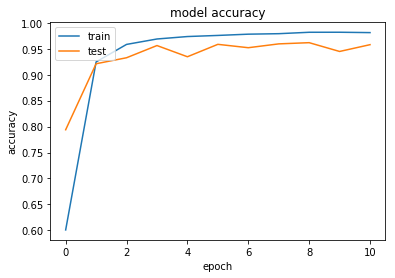

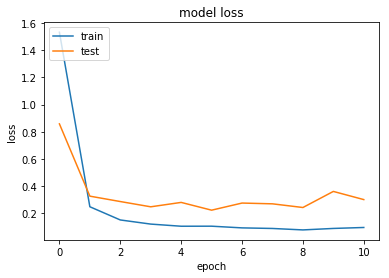

In [83]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Inception-v3 で転移学習
## データセット準備

In [2]:
import keras
from PIL import Image
from keras.datasets import cifar10
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

def load_images(path):
    img_data=[]
    labels=[]
    idx_to_label = []
    i = -1
    for fruit in next(os.walk(path))[1]:   #  os.listdir(path):
        fruit_path = os.path.join(path,fruit)
        labels.append(fruit)
        i = i+1
        for img in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path,img)
            idx_to_label.append(i)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (150, 150))
            #  詳細　https://note.nkmk.me/python-opencv-bgr-rgb-cvtcolor/
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            img_data.append(image)
    return np.array(img_data),np.array(idx_to_label),labels  

train_data_path = './fruits-360/Training'
test_data_path = './fruits-360/Test'
X_train,y_train,labels_data = load_images(train_data_path)

X_test,y_test,label_data_garbage = load_images(test_data_path)

# floatに型変換
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# 各画素値を正規化
X_train/= 255.0
X_test/= 255.0

## ネットワーク構築と学習

In [3]:
from __future__ import print_function
import struct
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import optimizers
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config)
K.set_session(sess)

# 各種パラメータ
nb_classes = 74          # 分類するクラス数
nb_epoch = 50            # 最適化計算のループ回数
batch_size = 100          # 計算効率化のために分割された訓練データの１グループあたりのデータ数
img_rows, img_cols = 150, 150     # 入力画像の縦横pixel数  

model_weights = '/Users/okunagatatsuya/diveintocode-term2/sprint21/v3_model[%d].h5'

# データの水増し（Data Augmentation）
datagen = ImageDataGenerator(
                             rotation_range=180, #画像をランダムに回転する回転範囲．
                             horizontal_flip=True, #水平方向に入力をランダムに反転
                             fill_mode='nearest')

# 水増し画像を訓練用画像の形式に合わせる
datagen.fit(X_train)

# クラスラベル y （数字の0~73）を、one-hotエンコーディング型式に変換
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

# IntercptionV3モデルと学習済みの重みをロード（全結合層は除く）
input_tensor = Input(shape=(img_rows, img_cols,3))
# include_top:ネットワークの出力層側にある3つの全結合層を含むかどうか
v3_model=InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 全結合層の構築
top_model = Sequential()
top_model.add(Flatten(input_shape=v3_model.output_shape[1:]))
top_model.add(Dense(256))
top_model.add(Activation("relu"))
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes))
top_model.add(Activation("softmax"))

model = Model(input=v3_model.input, output=top_model(v3_model.output))

for layer in v3_model.layers:
    layer.trainable = False

# モデルのコンパイル
# 学習のためのモデルを設定
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# 過学習の抑制
early_stopping = EarlyStopping(monitor='val_loss', patience=5 , verbose=1)

# 評価に用いるモデル重みデータの保存
checkpointer = ModelCheckpoint(model_weights, monitor='val_loss', 
                               verbose=1, save_best_only=True)

# リアルタイムに水増し生成されるバッチ画像に対するモデルの適用
history =model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                          samples_per_epoch=X_train.shape[0],
                          nb_epoch=nb_epoch,
                          verbose=1,
                          validation_data=(X_test, y_test),
                          callbacks=[early_stopping, checkpointer])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 評価に用いるモデル構造の保存
def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir("v3_model"):
        os.mkdir("v3_model")
    json_name = "v3_architecture.json"
    open(os.path.join("v3_model", json_name),"w").write(json_string)

save_model(model)

/Users/okunagatatsuya/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
/Users/okunagatatsuya/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/Users/okunagatatsuya/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=1, validation_data=(array([[[..., callbacks=[<keras.

Epoch 1/50
371/371 [==============================] - 1840s 5s/step - loss: 2.4805 - acc: 0.4087 - val_loss: 7.1323 - val_acc: 0.2006

Epoch 00001: val_loss improved from inf to 7.13230, saving model to /Users/okunagatatsuya/diveintocode-term2/sprint21/v3_model[%d].h5
Epoch 2/50
371/371 [==============================] - 1740s 5s/step - loss: 0.9171 - acc: 0.7480 - val_loss: 7.5282 - val_acc: 0.2189

Epoch 00002: val_loss did not improve from 7.13230
Epoch 3/50
371/371 [==============================] - 1805s 5s/step - loss: 0.6633 - acc: 0.8120 - val_loss: 7.0433 - val_acc: 0.2668

Epoch 00003: val_loss improved from 7.13230 to 7.04331, saving model to /Users/okunagatatsuya/diveintocode-term2/sprint21/v3_model[%d].h5
Epoch 4/50
371/371 [==============================] - 1741s 5s/step - loss: 0.5497 - acc: 0.8437 - val_loss: 8.1474 - val_acc: 0.2526

Epoch 00004: val_loss did not improve from 7.04331
Epoch 5/50
371/371 [==============================] - 1764s 5s/step - loss: 0.4996 - a

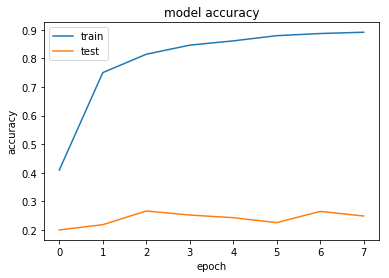

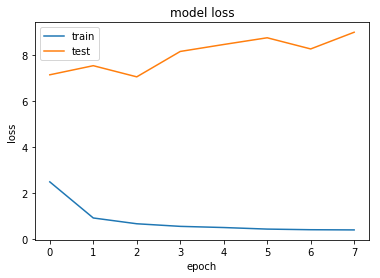

In [4]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()